In [1]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

fearful
savee
calm
happy
bdes
surprised
angry
sad
keywords


In [3]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [4]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [5]:
# This function prints metrics about a model
def print_metrics(voice_module, X, Y, label_name_list):
    Y_pred = voice_module.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [6]:
# Create class
class EmotionClassifierLstm(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # This first layer add noises to the input data and serve as a data augmentation technique
        # Used to prevent overfitting of the LSTM layer and try to extract more significant feature
        model.add(GaussianNoise(0.4))
        # This layer normalise the data to speed up the training and prevent the gradient of the LSTM to explode
        # and reach exponential weight value
        model.add(BatchNormalization())
        # This is THE feature extraction layer
        model.add(LSTM(128, input_shape=(128, 13), kernel_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(BatchNormalization())
        # This is the second part of the network, this one will be fine tuned later
        model.add(GaussianNoise(0.2))
        # The two last layers will be fine-tuned at the end of this notebook
        model.add(Dense(64))
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=128, padding='post')[0]
        return to_process


In [7]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=3
step=2

logger = PerformanceLogger()

cls = EmotionClassifierLstm()
vm = VoiceModule("emotion", emotion_list, cls)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad
Done


In [8]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}-{vm._name}.npy"

In [10]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [9]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [10]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

769 193
(128, 13)
float32


In [ ]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 769 samples, validate on 193 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
769/769 [==============================] - 8s 10ms/sample - loss: 1.8828 - acc: 0.1990 - val_loss: 1.8023 - val_acc: 0.1606
Epoch 2/100
769/769 [==============================] - 5s 6ms/sample - loss: 1.7344 - acc: 0.3121 - val_loss: 1.7458 - val_acc: 0.2124
Epoch 3/100
769/769 [==============================] - 5s 6ms/sample - loss: 1.5916 - acc: 0.3524 - val_loss: 1.6971 - val_acc: 0.2746
Epoch 4/100
769/769 [==============================] - 5s 7ms/sample - loss: 1.4726 - acc: 0.3810 - val_loss: 1.6685 - val_acc: 0.3212
Epoch 5/100
769/769 [==============================] - 5s 6ms/sample - loss: 1.4066 - acc: 0.4187 - val_loss: 1.6329 - val_acc: 0.2746
Epoch 6/100
769/769 [==============================] - 5s 6ms/sample - loss: 1.2844 - acc: 0.4603 - val_loss: 1.5940 - val_acc: 0.2642
Epoch 7/100
769/769 [============================

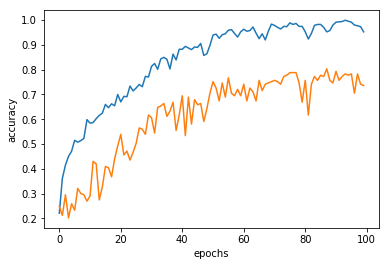

[[20  5  0  0  6]
 [ 0 38  0  3  4]
 [ 1 13 25  0  2]
 [ 0  6  1 29  3]
 [ 1  4  0  2 30]]
              precision    recall  f1-score   support

        calm       0.91      0.65      0.75        31
       happy       0.58      0.84      0.68        45
       angry       0.96      0.61      0.75        41
     fearful       0.85      0.74      0.79        39
         sad       0.67      0.81      0.73        37

    accuracy                           0.74       193
   macro avg       0.79      0.73      0.74       193
weighted avg       0.78      0.74      0.74       193



In [17]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(vm, X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [18]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_lstm.model")

In [18]:
# Now we save the model so we don't have to retrain it each time
vm.model.load("emotion_lstm.model")

In [19]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [ ]:
np.save(f"X_savee_{emotion_list}-{vm._name}", X_savee)
np.save(f"Y_savee_{emotion_list}-{vm._name}", Y_savee)

In [20]:
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(vm, X_savee, Y_savee, emotion_list)

360/360 [==============================] - 1s 2ms/sample - loss: 6.2077 - acc: 0.2222
[[ 9 47  5  0  9]
 [ 9 48 11  0  4]
 [ 5 48 12  1  2]
 [ 6 40 14  2  3]
 [11 59  6  0  9]]
              precision    recall  f1-score   support

        calm       0.23      0.13      0.16        70
       happy       0.20      0.67      0.31        72
       angry       0.25      0.18      0.21        68
     fearful       0.67      0.03      0.06        65
         sad       0.33      0.11      0.16        85

    accuracy                           0.22       360
   macro avg       0.33      0.22      0.18       360
weighted avg       0.33      0.22      0.18       360



In [21]:
# Now we freeze every layer used for extracting features from data
savee_model = keras.models.clone_model(vm.model._model)
for layer in savee_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
savee_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
savee_cls = EmotionClassifierLstm()
savee_cls._model = savee_model
savee_vm = VoiceModule("emotion", emotion_list, savee_cls)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
gaussian_noise_2
batch_normalization_2
lstm_1
activation_2
flatten_1
batch_normalization_3
gaussian_noise_3


In [22]:
# And we train the two last layers
# This is classic fine tuning
savee_vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 288 samples, validate on 72 samples
Epoch 1/100
288/288 [==============================] - 3s 11ms/sample - loss: 1.9156 - acc: 0.2014 - val_loss: 1.8587 - val_acc: 0.1111
Epoch 2/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.9065 - acc: 0.1840 - val_loss: 1.8603 - val_acc: 0.2639
Epoch 3/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8898 - acc: 0.2153 - val_loss: 1.8613 - val_acc: 0.2639
Epoch 4/100
288/288 [==============================] - 2s 5ms/sample - loss: 1.9251 - acc: 0.1910 - val_loss: 1.8615 - val_acc: 0.2639
Epoch 5/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.9054 - acc: 0.1806 - val_loss: 1.8635 - val_acc: 0.2639
Epoch 6/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8757 - acc: 0.2431 - val_loss: 1.8599 - val_acc: 0.2639
Epoch 7/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8984 - acc: 0.1562 - val_loss: 1.8597 - val_acc: 0.2639
Epoch 8/1

Epoch 61/100
288/288 [==============================] - 1s 5ms/sample - loss: 1.8771 - acc: 0.1875 - val_loss: 1.8628 - val_acc: 0.2639
Epoch 62/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8723 - acc: 0.2083 - val_loss: 1.8612 - val_acc: 0.2639
Epoch 63/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8803 - acc: 0.2049 - val_loss: 1.8622 - val_acc: 0.2639
Epoch 64/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8736 - acc: 0.1979 - val_loss: 1.8624 - val_acc: 0.2639
Epoch 65/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8543 - acc: 0.2882 - val_loss: 1.8630 - val_acc: 0.2639
Epoch 66/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8761 - acc: 0.2326 - val_loss: 1.8614 - val_acc: 0.2639
Epoch 67/100
288/288 [==============================] - 2s 6ms/sample - loss: 1.8695 - acc: 0.2188 - val_loss: 1.8623 - val_acc: 0.2639
Epoch 68/100
288/288 [==========================

In [23]:
print_metrics(savee_vm, X_savee_test, Y_savee_test, emotion_list)

[[ 0  0  0  0 16]
 [ 0  0  0  0 18]
 [ 0  0  0  0  9]
 [ 0  0  0  0 10]
 [ 0  0  0  0 19]]
              precision    recall  f1-score   support

        calm       0.00      0.00      0.00        16
       happy       0.00      0.00      0.00        18
       angry       0.00      0.00      0.00         9
     fearful       0.00      0.00      0.00        10
         sad       0.26      1.00      0.42        19

    accuracy                           0.26        72
   macro avg       0.05      0.20      0.08        72
weighted avg       0.07      0.26      0.11        72



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/bdes"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_bdes, Y_bdes = preprare_wav(data, vm, sample_duration, step)
X_bdes = X_bdes.astype('float32')
X_bdes_train, X_bdes_test, Y_bdes_train, Y_bdes_test = train_test_split(X_bdes, Y_bdes, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [25]:
np.save(f"X_bdes_{vm._name}", X_bdes)
np.save(f"Y_bdes_{vm._name}", Y_bdes)

In [31]:
vm.model._model.evaluate(X_bdes, Y_bdes)
print_metrics(vm, X_bdes, Y_bdes, emotion_list)

388/388 [==============================] - 1s 3ms/sample - loss: 5.8306 - acc: 0.2861
[[ 0 47 25  7  0]
 [ 1 33 34  3  0]
 [ 0 19 65  4  0]
 [ 0 21 40  8  0]
 [14 37 10 15  5]]
              precision    recall  f1-score   support

        calm       0.00      0.00      0.00        79
       happy       0.21      0.46      0.29        71
       angry       0.37      0.74      0.50        88
     fearful       0.22      0.12      0.15        69
         sad       1.00      0.06      0.12        81

    accuracy                           0.29       388
   macro avg       0.36      0.28      0.21       388
weighted avg       0.37      0.29      0.22       388



In [32]:
# Now we freeze every layer used for extracting features from data
bdes_model = keras.models.clone_model(vm.model._model)
for layer in bdes_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
bdes_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bdes_cls = EmotionClassifierLstm()
bdes_cls._model = bdes_model
bdes_vm = VoiceModule("emotion", emotion_list, bdes_cls)

gaussian_noise_2
batch_normalization_2
lstm_1
activation_2
flatten_1
batch_normalization_3
gaussian_noise_3


In [33]:
# And we train the two last layers
# This is classic fine tuning
bdes_vm.model.train(X_bdes_train, Y_bdes_train, batch_size=10, validation_data=(X_bdes_test, Y_bdes_test), epoch=100)

Train on 310 samples, validate on 78 samples
Epoch 1/100
310/310 [==============================] - 5s 16ms/sample - loss: 1.8981 - acc: 0.1613 - val_loss: 1.8674 - val_acc: 0.1923
Epoch 2/100
310/310 [==============================] - 3s 9ms/sample - loss: 1.9033 - acc: 0.2194 - val_loss: 1.8679 - val_acc: 0.1923
Epoch 3/100
310/310 [==============================] - 3s 10ms/sample - loss: 1.9133 - acc: 0.1710 - val_loss: 1.8677 - val_acc: 0.1923
Epoch 4/100
310/310 [==============================] - 3s 11ms/sample - loss: 1.8736 - acc: 0.2258 - val_loss: 1.8699 - val_acc: 0.1923
Epoch 5/100
310/310 [==============================] - 3s 11ms/sample - loss: 1.8972 - acc: 0.1839 - val_loss: 1.8706 - val_acc: 0.1923
Epoch 6/100
310/310 [==============================] - 3s 11ms/sample - loss: 1.8684 - acc: 0.2387 - val_loss: 1.8723 - val_acc: 0.1923
Epoch 7/100
310/310 [==============================] - 3s 11ms/sample - loss: 1.8908 - acc: 0.1871 - val_loss: 1.8741 - val_acc: 0.1923
Epoc

In [34]:
print_metrics(bdes_vm, X_bdes_test, Y_bdes_test, emotion_list)

[[ 0  0 23  0  0]
 [ 0  0 15  0  0]
 [ 0  0 15  0  0]
 [ 0  0 10  0  0]
 [ 0  0 15  0  0]]
              precision    recall  f1-score   support

        calm       0.00      0.00      0.00        23
       happy       0.00      0.00      0.00        15
       angry       0.19      1.00      0.32        15
     fearful       0.00      0.00      0.00        10
         sad       0.00      0.00      0.00        15

    accuracy                           0.19        78
   macro avg       0.04      0.20      0.06        78
weighted avg       0.04      0.19      0.06        78



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
